In [1]:
import geopandas as gpd

# visualize the osm objects within a chip

In [21]:
import os
import numpy as np
folder = '/opt/data/california-naip-chips/osm/'
files = os.listdir(folder)


In [28]:
file = np.random.choice(files)
z = gpd.read_parquet(f"{folder}/{file}")
z.explore()

## inspect and visualize the neighbours of a chip

In [44]:
import pandas as pd

In [35]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = os.listdir(folder)
file = np.random.choice(files)
file

'ca_m_3411750_ne_11_060_20220507-20-15.parquet'

In [45]:
z = pd.read_parquet(f"{folder}/{file}")
z

,chipid,lonm,latm,embeddings,distance
100,ca_m_3411750_ne_11_060_20220507-20-2,1.858960e+06,731934.933118,"[-0.08117495, 0.057754993, 0.066028476, 0.0196...",1997.629288
135,ca_m_3411750_ne_11_060_20220507-15-3,1.858191e+06,731786.659632,"[-0.06769271, 0.054604527, 0.033200722, 0.0447...",1997.627525
136,ca_m_3411750_ne_11_060_20220507-16-3,1.858345e+06,731785.582375,"[-0.055297848, 0.049906395, 0.03207831, 0.0195...",1943.708852
137,ca_m_3411750_ne_11_060_20220507-17-3,1.858498e+06,731784.505059,"[-0.07833125, 0.06349342, 0.031076133, 0.05704...",1900.714977
138,ca_m_3411750_ne_11_060_20220507-18-3,1.858652e+06,731783.427682,"[-0.12422923, 0.046427187, 0.118039496, 0.0227...",1869.399831
...,...,...,...,...,...
1102,ca_m_3411750_ne_11_060_20220507-22-27,1.859241e+06,728091.284423,"[-0.0071347435, 0.06082721, 0.010516605, -0.03...",1869.392368
1103,ca_m_3411750_ne_11_060_20220507-23-27,1.859394e+06,728090.205749,"[-0.020341868, 0.0747143, 0.007444693, -0.0099...",1900.707912
1104,ca_m_3411750_ne_11_060_20220507-24-27,1.859548e+06,728089.127017,"[-0.080797344, 0.07031388, 0.0050179516, 0.066...",1943.702163
1105,ca_m_3411750_ne_11_060_20220507-25-27,1.859702e+06,728088.048228,"[-0.028598022, 0.06272048, -0.0034034986, -0.0...",1997.621199


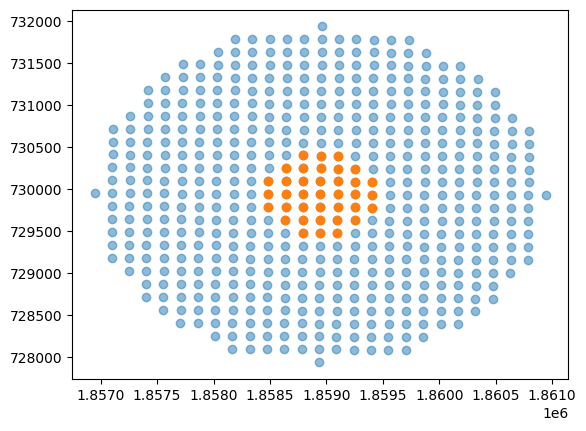

In [47]:
plt.scatter(z.lonm.values, z.latm.values, alpha=.5)
zz = z[z.distance<500]
plt.scatter(zz.lonm.values, zz.latm.values)

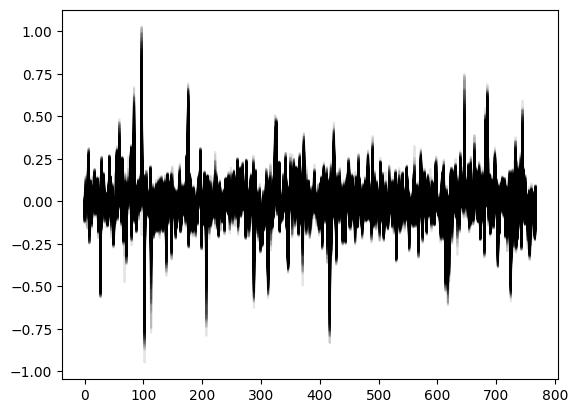

In [41]:
import matplotlib.pyplot as plt
for i in z[z.distance>1500].embeddings.values:
    plt.plot(i, color="black", alpha=.1)

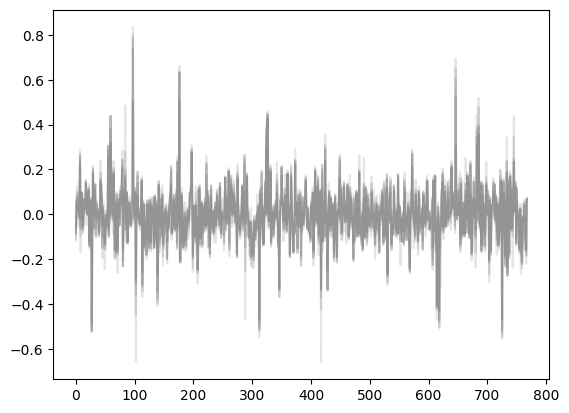

In [43]:
import matplotlib.pyplot as plt
for i in z[z.distance<200].embeddings.values:
    plt.plot(i, color="black", alpha=.1)

In [54]:
a = np.r_[6,3,3,6]
(a / 6).mean()


0.75

In [53]:
m  = np.array([[1, -1, -1, -1],
               [1, 1,  1, -1],
               [1, -1,  1, -1],
               [1, -1, -1, -1],
               [1,  1,  -1, -1],
               [1, 1,  1, -1 ]])
m

array([[ 1, -1, -1, -1],
       [ 1,  1,  1, -1],
       [ 1, -1,  1, -1],
       [ 1, -1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1,  1, -1]])

In [55]:
X = np.array([[1, 5, 1, 4, 8],
              [9, 7, 0, 7, 9],
              [0, 6, 3, 0, 6]])
v = np.array([9, 7, 0, 7, 9])

In [58]:
np.linalg.norm(X-v, axis=1)

array([ 8.88819442,  0.        , 12.20655562])